*Álvaro Francisco Gil*

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alvaro-francisco-gil/nn4nlp/blob/main/exercises/02_convolutions_sentiment_analysis.ipynb) 
[![View on GitHub](https://img.shields.io/badge/Open%20on-GitHub-blue?logo=github)](https://github.com/alvaro-francisco-gil/nn4nlp/blob/main/exercises/02_convolutions_sentiment_analysis.ipynb)



This practice is similar to the previous one until the encoding part.

[Jump to Encoding](#Encoding)

In [1]:
import re
import string
from collections import Counter
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
print(torch.cuda.is_available())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


# Analyze Data

In [2]:
train_file = '/root/nn4nlp/data/train_reviews.csv'
df = pd.read_csv(train_file)
df.head()

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive


In [3]:
df.shape

(8000, 3)

In [4]:
test_file = '/root/nn4nlp/data/test_reviews.csv'
test_df = pd.read_csv(test_file)
test_df.head()

,id,review,sentiment
0,6666,Movies about dinosaurs can be entertaining. So...,negative
1,23267,If it's action and adventure you want in a mov...,positive
2,2897,Barbra Streisand is a tour de force in this Ho...,positive
3,23177,I borrowed this movie despite its extremely lo...,positive
4,14171,"""Baby Face"" is a precode melodrama starring a ...",positive


In [5]:
test_df.shape

(2000, 3)

## Check class balance

In [6]:
df.value_counts('sentiment')

sentiment
positive    4012
negative    3988
Name: count, dtype: int64

In [7]:
test_df.value_counts('sentiment')

sentiment
negative    1025
positive     975
Name: count, dtype: int64

Both classes are balanced

## Check missing values

In [8]:
df.isna().sum()


id           0
review       0
sentiment    0
dtype: int64

In [9]:
test_df.isna().sum()

id           0
review       0
sentiment    0
dtype: int64

## Visual Inspection

In [10]:
df.iloc[1]['review']

"I have been wanting to see cut since the day i have heard of it, which was sometime last year. Anyway i got to see today, and when the movie started i thought that it started rather week but it got better after 10 mins or so. I thought that the movie was pretty good. but the thing i didn't like was how the killer was created, i was thinking just before i rented that it would probably suck just like Urban legends: final cut, i almost died it. mostly everything in UL final cut needed to be improved. CUT is 100 times better than UL:final cut. The best part of CUT is the killer and the death scenes. The killer kicks MO F***ING ASS.<br /><br />i give cut a 8 out of 10"

In [11]:
df.iloc[2]['review']

'This movie is terrible. The suspense is spent waiting for a point. There isn\'t much of one.<br /><br />Aside from a few great lines ( "I found a tooth in my apartment" ), and the main characters dedication to killing himself, it\'s a collection of supposedly eerie sounds.<br /><br />'

Insigths:
- Needd to remove HTML labels
- Not in lowercase

## Word Histogram

In [12]:
def plot_word_histogram(text_array):
    # Convert input to a flat list of strings
    if isinstance(text_array, str):
        # If it's a single string, convert to list
        text_array = [text_array]
    elif isinstance(text_array, list):
        # Flatten nested lists and ensure all elements are strings
        flattened = []
        for item in text_array:
            if isinstance(item, list):
                flattened.extend(item)
            else:
                flattened.append(item)
        text_array = [str(item) for item in flattened]
    else:
        raise ValueError("Input must be a string or a list of strings.")

    # Join all text into one string
    all_text = ' '.join(text_array)

    # Tokenize words by splitting on whitespace
    words = all_text.split()

    # Count word frequencies
    word_counts = Counter(words)
    labels, values = zip(*word_counts.items())

    # Sort by frequency in descending order
    sorted_indices = np.argsort(values)[::-1]
    labels = np.array(labels)[sorted_indices]
    values = np.array(values)[sorted_indices]

    # Plot the histogram for the top 10 most frequent words
    plt.figure(figsize=(10, 6))
    plt.bar(labels[:10], values[:10], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

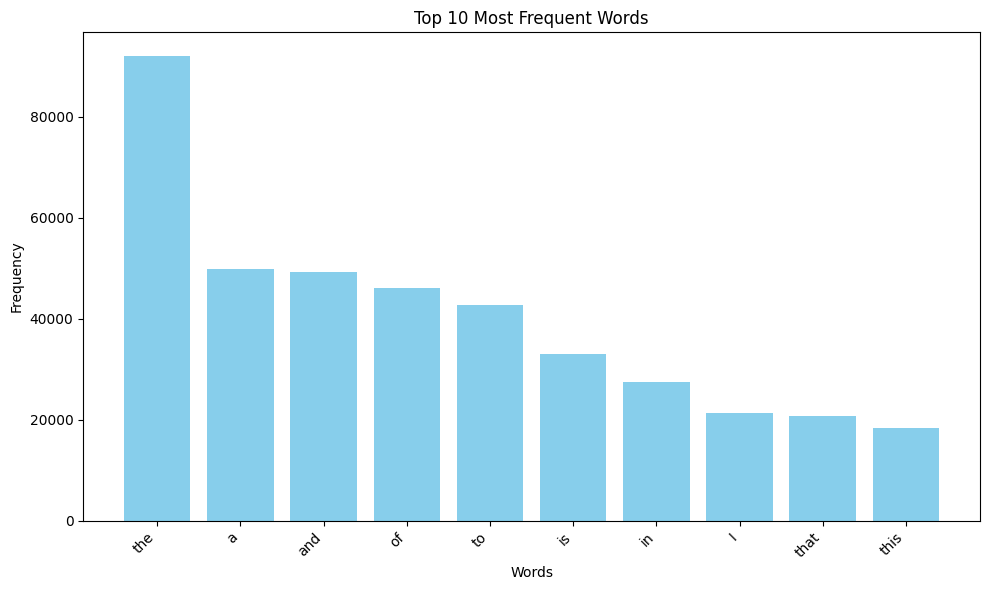

In [13]:
plot_word_histogram(df['review'].to_list())

# Pre-processing

In [14]:
data = np.concatenate([df['review'].values,test_df['review'].values],axis=0)
raw_data = data
data.shape

(10000,)

## Remove HTML labels

In [15]:
def clean_htmls_text_array(text_array):

    def remove_html_tags(text):
        pattern = re.compile('<.*?>')
        clean_text = re.sub(pattern, '', text)
        clean_text = ' '.join(clean_text.split())
        return clean_text

    cleaned_array = [remove_html_tags(text) for text in text_array]

    return cleaned_array

In [16]:
data[1][-40:]

'ASS.<br /><br />i give cut a 8 out of 10'

In [17]:
data = clean_htmls_text_array(data)

In [18]:
data[1][-40:]

' MO F***ING ASS.i give cut a 8 out of 10'

## Downcase

In [19]:
def lowercase_array(text_array):
    return [text.lower() for text in text_array]

In [20]:
data = lowercase_array(data)

In [21]:
data[1][-40:]

' mo f***ing ass.i give cut a 8 out of 10'

I don't want to remove the numbers as they may contain valuable information for the classifier, as in this case: "8 out of 10"

I test the hypothesis:

In [22]:
def find_term_with_context(text_array, term, context_chars=5):
    occurrences = 0
    occurrences_list = []

    for text in text_array:
        start = 0
        while (start := text.find(term, start)) != -1:
            occurrences += 1
            context_start = max(0, start - context_chars)
            context_end = min(len(text), start + len(term) + context_chars)
            context = text[context_start:context_end]

            occurrences_list.append(f"...{context}...")
            start += len(term)

    print(f"\nTotal occurrences of '{term}': {occurrences}")
    return occurrences, occurrences_list

In [23]:
_,ocurrences = find_term_with_context(data, 'out of')
ocurrences[1]


Total occurrences of 'out of': 2070


'... a 3 out of 10, ...'

We see that 2070 reviews contain a possible explicit grade

## Expand Contractions

In [24]:
def expand_contractions(texts):
    contractions = {
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }
    def expand(text):
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        return text
    return [expand(text) for text in texts]

In [25]:
data[0][330:380]

"a never-ending murder spree. it's not a highly ori"

In [26]:
data = expand_contractions(data)

In [27]:
data[0][330:380]

'a never-ending murder spree. it is not a highly or'

## Remove Punctuation

In [28]:
def remove_punctuation(texts):
    translator = str.maketrans('', '', string.punctuation)
    return [text.translate(translator) for text in texts]

In [29]:
data = remove_punctuation(data)

In [30]:
data[0][330:380]

'erending murder spree it is not a highly original '

## Tokenization

In [31]:
def tokenize_texts(texts):
    return [word_tokenize(text) for text in texts]

In [32]:
data = tokenize_texts(data)

In [33]:
data[0][:5]

['people', 'tried', 'to', 'make', 'me']

## Lemmatization

In [34]:
def lemmatize_texts(tokenized_texts):
    lemmatizer = WordNetLemmatizer()
    return [[lemmatizer.lemmatize(word) for word in text] for text in tokenized_texts]

In [35]:
data[0][29]

'escapes'

In [36]:
data = lemmatize_texts(data)

In [37]:
data[0][29]

'escape'

## Stopword Removal

In [38]:
def remove_stopwords(tokenized_texts):
    stop_words = set(stopwords.words('english'))
    return [[word for word in text if word.lower() not in stop_words] for text in tokenized_texts]

In [39]:
data[0][:7]

['people', 'tried', 'to', 'make', 'me', 'believe', 'that']

In [40]:
data = remove_stopwords(data)

In [41]:
data[0][:7]

['people', 'tried', 'make', 'believe', 'premise', 'rubbishy', 'supernatural']

## Preprocessing Function

The lemmatization is not needed as for word2vec it is better to keep the original words

In [42]:
def preprocess_data(data):
    data = clean_htmls_text_array(data)
    data = lowercase_array(data)
    data = expand_contractions(data)
    data = remove_punctuation(data)
    data = tokenize_texts(data)
    # data = lemmatize_texts(data)
    data = remove_stopwords(data)
    return data

In [43]:
processed_data = preprocess_data(raw_data)

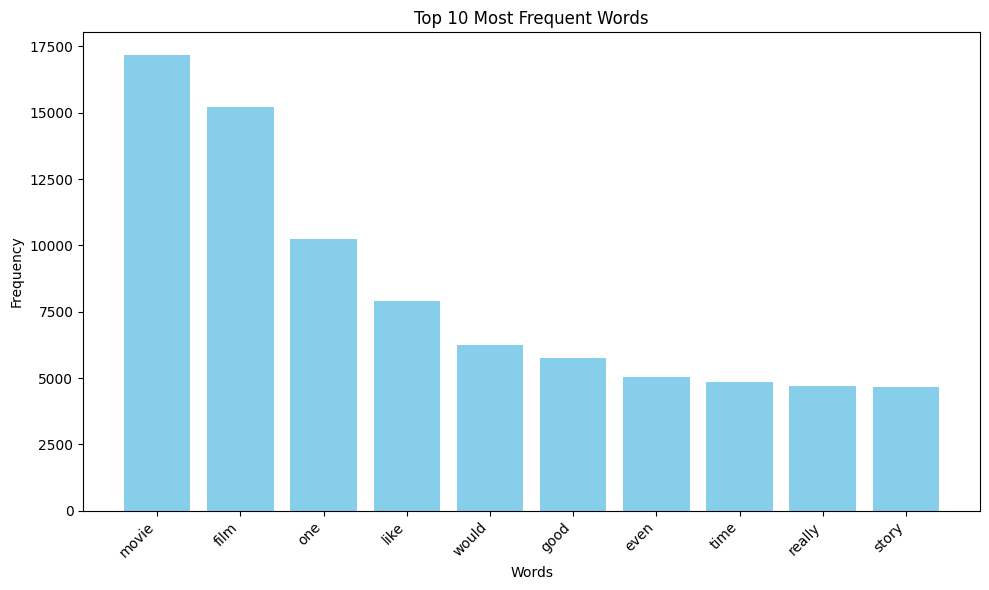

In [44]:
plot_word_histogram(processed_data)

# Encoding

There is a decision to be made here on the encoding scheme. I will use Word2Vec and GloVe embeddings instead of TF-IDF or Bag-of-Words (BoW) because it produces smaller output dimensions, and now that we have a recurrent network, we can use the concatenated word embeddings as the input for the network.

In [45]:
combined_sentiments = np.concatenate([df['sentiment'].values, test_df['sentiment'].values])
combined_sentiments.shape

(10000,)

The added parameter aggregate is used to decide if the word embeddings should be aggregated or not.

In [46]:
def encode_text(data: List[List[str]], labels: List[str], encoding: str = 'word2vec', train_size: int = 8000, aggregate: bool = True, dimensions: int = 100) -> Tuple:
    # Encode the sentiment labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Split the data
    X_train = data[:train_size]
    X_test = data[train_size:]
    y_train = y_encoded[:train_size]
    y_test = y_encoded[train_size:]

    if encoding == 'word2vec':
        # Train Word2Vec model
        w2v_model = Word2Vec(sentences=data, vector_size=dimensions, window=5, min_count=1, workers=4)
        embeddings = w2v_model.wv
        
        if aggregate:
            def document_vector(doc):
                word_vectors = [embeddings[word] for word in doc if word in embeddings]
                return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(dimensions)
        else:
            def word_vectors_for_document(doc):
                return np.array([embeddings[word] for word in doc if word in embeddings])

    elif encoding == 'glove':
        # Load pre-trained GloVe embeddings
        embeddings = {}
        with open(f'/root/nn4nlp/data/embeddings/glove.6B.{dimensions}d.txt', 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector

        if aggregate:
            def document_vector(doc):
                word_vectors = [embeddings[word] for word in doc if word in embeddings]
                return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(dimensions)
        else:
            def word_vectors_for_document(doc):
                return np.array([embeddings[word] for word in doc if word in embeddings])
    
    else:
        raise ValueError("encoding must be either 'word2vec' or 'glove'")

    if aggregate:
        X_train_encoded = np.array([document_vector(doc) for doc in X_train])
        X_test_encoded = np.array([document_vector(doc) for doc in X_test])
    else:
        X_train_encoded = [word_vectors_for_document(doc) for doc in X_train]
        X_test_encoded = [word_vectors_for_document(doc) for doc in X_test]

    return (X_train_encoded, X_test_encoded, y_train, y_test)


In [47]:
X_train, X_test, y_train, y_test = encode_text(data, combined_sentiments, encoding='word2vec', aggregate=False)

In [48]:
X_train, X_test, y_train, y_test = encode_text(data, combined_sentiments, encoding='glove', aggregate=False)

With the recurrent network, there is no need to pad the sequences as the network will handle the variable length of the input sequences.

# Modelling

Let's build an Early Stopping class to monitor validation loss and save best model, it will halt the training process when the validation loss does not improve for a given number of epochs: patience.

In [49]:
# Early stopping class to monitor validation loss and save best model
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        self.checkpoint_path = checkpoint_path
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            torch.save(self.best_model_state, self.checkpoint_path)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            torch.save(self.best_model_state, self.checkpoint_path)
            self.counter = 0
            
    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))
        return model

This function will train the model and return the best model, the training and validation losses, and the training and validation accuracies. Compared to the previous practice, this function handles variable length sequences by using a custom collate function to pad the sequences to the same length, which increases the training time.

In [50]:
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=10, batch_size=32, patience=5, verbose=False):
    # Initialize loss tracking
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Convert labels to tensors
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)

    # Create custom collate function to handle variable length sequences
    def collate_fn(batch):
        # Separate sequences and labels
        sequences = [torch.FloatTensor(item[0]) for item in batch]
        labels = torch.FloatTensor([item[1] for item in batch])
        return sequences, labels

    # Create data loaders with custom collate function
    train_dataset = list(zip(X_train, y_train))
    test_dataset = list(zip(X_test, y_test))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            # Process each sequence individually
            batch_outputs = []
            for sequence in batch_X:
                # Add batch dimension
                sequence = sequence.unsqueeze(0)
                # Get output
                output = model(sequence).squeeze()
                batch_outputs.append(output)
            
            # Stack outputs
            outputs = torch.stack(batch_outputs).squeeze()
            
            # Calculate loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate training accuracy
            predicted = (outputs >= 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                # Process each sequence individually
                batch_outputs = []
                for sequence in batch_X:
                    # Add batch dimension
                    sequence = sequence.unsqueeze(0)
                    # Get output
                    output = model(sequence).squeeze()
                    batch_outputs.append(output)
                
                # Stack outputs
                outputs = torch.stack(batch_outputs).squeeze()
                
                loss = criterion(outputs, batch_y)
                total_test_loss += loss.item()
                
                predicted = (outputs >= 0.5).float()
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        # Calculate average losses and accuracies
        avg_train_loss = total_train_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(test_loader)
        train_accuracy = 100 * train_correct / train_total
        test_accuracy = 100 * test_correct / test_total
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Test Loss: {avg_test_loss:.4f}')
            print(f'Training Accuracy: {train_accuracy:.2f}%')
            print(f'Test Accuracy: {test_accuracy:.2f}%')
            print('-' * 50)

        # Early stopping check
        early_stopping(model=model, val_loss=avg_test_loss)
        if early_stopping.early_stop:
            if verbose:
                print("Early stopping triggered")
            break

    # Plot training and test losses
    if verbose:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss Over Time')
        plt.legend()
        plt.show()
    
    # Load the best model before returning and remove the checkpoint file
    model.load_state_dict(torch.load('checkpoint.pt'))
    os.remove('checkpoint.pt')
    
    return model, train_losses, test_losses, train_accuracies, test_accuracies

We believe GRUs wouldn't be a good choice as they are not able to handle long-term dependencies because of vanishing gradients, and some of the reviews of this dataset are quite long. So the models we're going to try are LSTM and GRUs, both with the possibility of being bidirectional and stacked.

# SentimentLSTM

The SentimentLSTM class takes the following parameters:

- `input_size` (default=100): The dimensionality of word embeddings used as input

- `hidden_size` (default=64): The number of hidden units in each LSTM layer

- `num_layers` (default=2): The number of stacked LSTM layers in the model

- `dropout_rate` (default=0.5): The probability of dropping out neurons during training to prevent overfitting

- `bidirectional` (default=True): Whether to use bidirectional LSTM layers that process sequences in both directions

The model architecture consists of:
1. Stacked LSTM layers with configurable hidden size and bidirectional processing
2. A fully connected layer with ReLU activation and dropout
3. A final output layer with sigmoid activation for binary classification



In [51]:
# Create an LSTM model            
class SentimentLSTM(nn.Module):

    def __init__(self, 
                 input_size=100,
                 hidden_size=64,
                 num_layers=2,
                 dropout_rate=0.5,
                 bidirectional=True):
        super(SentimentLSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout_rate if num_layers > 1 else 0,
                           bidirectional=bidirectional)
        
        # Calculate output features size based on bidirectional
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Dense layer
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
            
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        
        # Dense layer
        x = self.fc(lstm_out)
            
        # Output layer
        x = self.output_layer(x)
        
        return x

Example of a SentimentLSTM model:

Epoch [1/10]
Training Loss: 0.6111
Test Loss: 0.6107
Training Accuracy: 65.58%
Test Accuracy: 67.60%
--------------------------------------------------
Epoch [2/10]
Training Loss: 0.5267
Test Loss: 0.5915
Training Accuracy: 74.94%
Test Accuracy: 69.15%
--------------------------------------------------
Epoch [3/10]
Training Loss: 0.5561
Test Loss: 0.6546
Training Accuracy: 72.85%
Test Accuracy: 63.30%
--------------------------------------------------
Epoch [4/10]
Training Loss: 0.5020
Test Loss: 0.4671
Training Accuracy: 76.70%
Test Accuracy: 77.20%
--------------------------------------------------
Epoch [5/10]
Training Loss: 0.4473
Test Loss: 0.4374
Training Accuracy: 79.58%
Test Accuracy: 80.80%
--------------------------------------------------
Epoch [6/10]
Training Loss: 0.3990
Test Loss: 0.4158
Training Accuracy: 82.44%
Test Accuracy: 81.20%
--------------------------------------------------
Epoch [7/10]
Training Loss: 0.3760
Test Loss: 0.3980
Training Accuracy: 84.19%
Test Accu

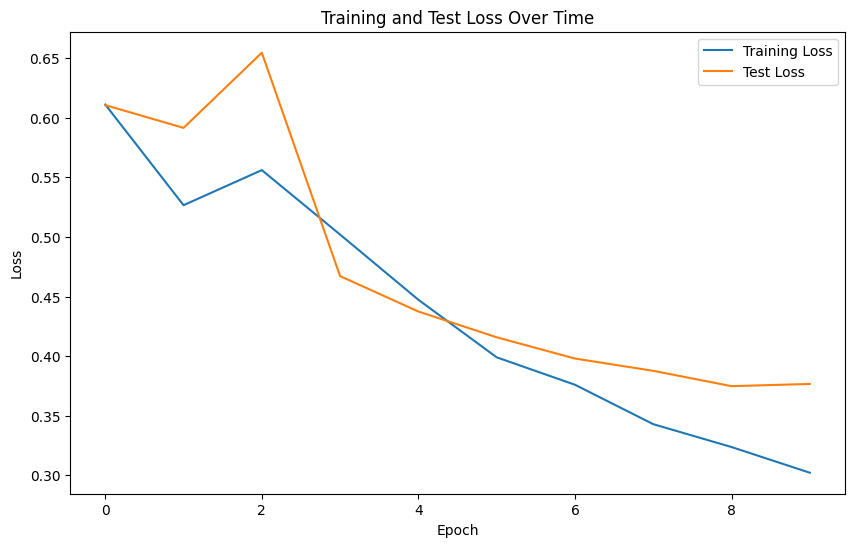

In [52]:
model = SentimentLSTM()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

lstm_model, lstm_train_losses, lstm_test_losses, lstm_train_accuracies, lstm_test_accuracies = train_model(model, X_train, y_train, X_test, y_test, num_epochs=10, verbose=True)

In [53]:
# Save lstm model
torch.save(lstm_model, '/root/nn4nlp/models/03_lstm_model.pt')
lstm_model = torch.load('/root/nn4nlp/models/03_lstm_model.pt')

# SentimentGRU

The SentimentGRU class takes the following parameters:

- `input_size` (default=100): The dimensionality of word embeddings used as input

- `hidden_size` (default=64): The number of hidden units in each GRU layer

- `num_layers` (default=2): The number of stacked GRU layers in the model

- `dropout_rate` (default=0.5): The probability of dropping out neurons during training to prevent overfitting

- `bidirectional` (default=True): Whether to use bidirectional GRU layers that process sequences in both directions

The model architecture consists of:
1. Stacked GRU layers with configurable hidden size and bidirectional processing
2. A fully connected layer with ReLU activation and dropout
3. A final output layer with sigmoid activation for binary classification


In [54]:
class SentimentGRU(nn.Module):

    def __init__(self, 
                 input_size=100,
                 hidden_size=64,
                 num_layers=1,
                 dropout_rate=0.5,
                 bidirectional=True):
        super(SentimentGRU, self).__init__()
        
        # GRU layer
        self.gru = nn.GRU(input_size=input_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         batch_first=True,
                         dropout=dropout_rate if num_layers > 1 else 0,
                         bidirectional=bidirectional)
        
        # Calculate output features size based on bidirectional
        gru_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Dense layer
        self.fc = nn.Sequential(
            nn.Linear(gru_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
            
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # GRU layer
        gru_out, _ = self.gru(x)
        
        # Take the output from the last time step
        gru_out = gru_out[:, -1, :]
        
        # Dense layer
        x = self.fc(gru_out)
            
        # Output layer
        x = self.output_layer(x)
        
        return x

Example of a SentimentGRU model:

Epoch [1/10]
Training Loss: 0.5653
Test Loss: 0.4717
Training Accuracy: 70.91%
Test Accuracy: 77.95%
--------------------------------------------------
Epoch [2/10]
Training Loss: 0.4356
Test Loss: 0.4154
Training Accuracy: 80.36%
Test Accuracy: 81.95%
--------------------------------------------------
Epoch [3/10]
Training Loss: 0.3756
Test Loss: 0.3770
Training Accuracy: 83.55%
Test Accuracy: 84.10%
--------------------------------------------------
Epoch [4/10]
Training Loss: 0.3420
Test Loss: 0.3955
Training Accuracy: 85.96%
Test Accuracy: 82.75%
--------------------------------------------------
Epoch [5/10]
Training Loss: 0.3170
Test Loss: 0.3649
Training Accuracy: 86.47%
Test Accuracy: 84.65%
--------------------------------------------------
Epoch [6/10]
Training Loss: 0.2916
Test Loss: 0.4049
Training Accuracy: 87.69%
Test Accuracy: 83.00%
--------------------------------------------------
Epoch [7/10]
Training Loss: 0.2706
Test Loss: 0.4059
Training Accuracy: 89.01%
Test Accu

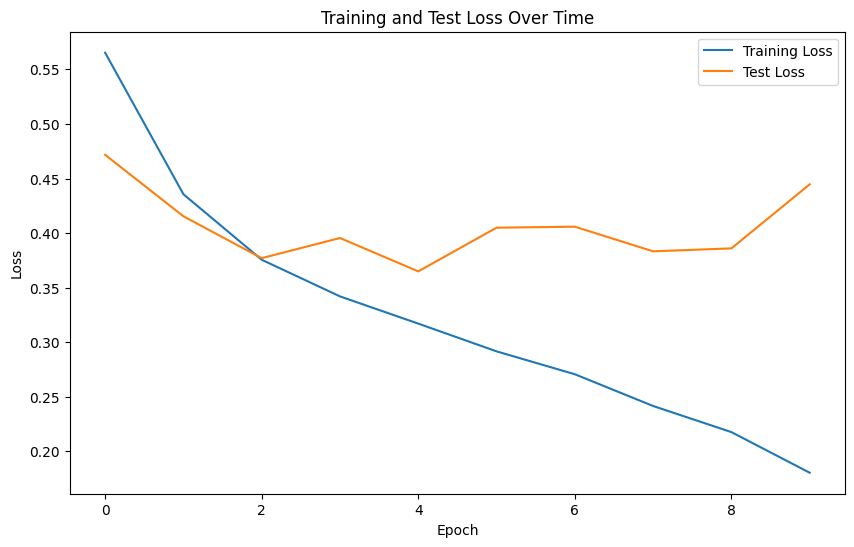

In [55]:
model = SentimentGRU()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

gru_model, gru_train_losses, gru_test_losses, gru_train_accuracies, gru_test_accuracies = train_model(model, X_train, y_train, X_test, y_test, num_epochs=10, verbose=True)

In [56]:
# Save gru model
torch.save(gru_model, '/root/nn4nlp/models/03_gru_model.pt')
gru_model = torch.load('/root/nn4nlp/models/03_gru_model.pt')

# SentimentRNN

The SentimentRNN class takes the following parameters:

- `input_size` (default=100): The dimensionality of word embeddings used as input

- `hidden_size` (default=64): The number of hidden units in each RNN layer

- `num_layers` (default=2): The number of stacked RNN layers in the model

- `dropout_rate` (default=0.5): The probability of dropping out neurons during training to prevent overfitting

- `rnn_type` (default='lstm'): The type of RNN layer to use, either 'lstm' or 'gru'

- `bidirectional` (default=True): Whether to use bidirectional RNN layers that process sequences in both directions 

The model architecture consists of:
1. Stacked RNN layers with configurable hidden size and bidirectional processing
2. A fully connected layer with ReLU activation and dropout
3. A final output layer with sigmoid activation for binary classification


In [57]:
class SentimentRNN(nn.Module):
    def __init__(self,
                 input_size=100,
                 hidden_size=64,
                 num_layers=1,
                 dropout_rate=0.5,
                 rnn_type='lstm',
                 bidirectional=True):
        super(SentimentRNN, self).__init__()
        
        self.rnn_type = rnn_type.lower()
        
        # Choose RNN type
        if self.rnn_type == 'lstm':
            rnn_layer = nn.LSTM
        elif self.rnn_type == 'gru':
            rnn_layer = nn.GRU
        else:
            raise ValueError("rnn_type must be either 'lstm' or 'gru'")
            
        # Stacked RNN layers
        self.rnn = rnn_layer(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout_rate if num_layers > 1 else 0,
                           bidirectional=bidirectional)
        
        # Calculate output features size based on bidirectional
        rnn_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Dense layer
        self.fc = nn.Sequential(
            nn.Linear(rnn_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
            
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # RNN layers
        rnn_out, _ = self.rnn(x)
        
        # Take the output from the last time step
        rnn_out = rnn_out[:, -1, :]
        
        # Dense layer
        x = self.fc(rnn_out)
            
        # Output layer
        x = self.output_layer(x)
        
        return x

The class above is a combination of SentimentLSTM and SentimentGRU, so it can be used as either LSTM or GRU.

# Grid Search

The following parameter grid have been chosen because they are the most important parameters to consider when training a recurrent network.

In [58]:
# Define parameter grid
PARAM_GRID = {
    'encoding': ['glove', 'word2vec'],
    'dimensions_embedding': [100],
    'hidden_size': [64, 128],
    'num_layers': [1, 2],
    'dropout_rate': [0.2],
    'rnn_type': ['lstm', 'gru'],
    'bidirectional': [True, False]
}

num_epochs = 10
patience = 5

In [59]:
def grid_search_sentiment_rnn(processed_data, combined_sentiments, num_epochs=num_epochs, patience=patience, verbose=False):
    # Replace full param grid with test grid if specified
    param_grid = PARAM_GRID

    # Store results
    results = []
    best_model = None

    # Grid search
    for encoding in param_grid['encoding']:
        for dimensions_embedding in param_grid['dimensions_embedding']:
            for hidden_size in param_grid['hidden_size']:
                for num_layers in param_grid['num_layers']:
                    for dropout_rate in param_grid['dropout_rate']:
                        for rnn_type in param_grid['rnn_type']:
                            for bidirectional in param_grid['bidirectional']:

                                # Data
                                X_train, X_test, y_train, y_test = encode_text(
                                    processed_data,
                                    combined_sentiments,
                                    train_size=8000,
                                    aggregate=False,
                                    dimensions=dimensions_embedding,
                                    encoding=encoding)

                                # Initialize model with current parameters
                                model = SentimentRNN(
                                    input_size=dimensions_embedding,
                                    hidden_size=hidden_size,
                                    num_layers=num_layers,
                                    dropout_rate=dropout_rate,
                                    rnn_type=rnn_type,
                                    bidirectional=bidirectional
                                )
                                
                                # Train model
                                train_losses = []
                                test_losses = []
                                train_accuracies = []
                                test_accuracies = []
                                
                                # Train model
                                model, train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                                    model, 
                                    X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test, 
                                    num_epochs=num_epochs,
                                    patience=patience,
                                    verbose=verbose
                                )
                                                                
                                # Store results
                                result = {
                                    'encoding': encoding,
                                    'dimensions_embedding': dimensions_embedding,
                                    'hidden_size': hidden_size,
                                    'num_layers': num_layers,
                                    'dropout_rate': dropout_rate,
                                    'rnn_type': rnn_type,
                                    'bidirectional': bidirectional,
                                    'final_train_loss': min(train_losses),
                                    'final_test_loss': min(test_losses),
                                    'final_train_accuracy': max(train_accuracies),
                                    'final_test_accuracy': max(test_accuracies)
                                }
                                results.append(result)
                                
                                # Update best model if current is better
                                if not best_model or result['final_test_accuracy'] > best_result['final_test_accuracy']:
                                    best_model = model
                                    best_result = result

    # Find best model based on test accuracy
    best_result = max(results, key=lambda x: x['final_test_accuracy'])
    print("\nBest parameters:")
    print(f"Model parameters:")
    print(f"Hidden size: {best_result['hidden_size']}")
    print(f"Number of layers: {best_result['num_layers']}")
    print(f"RNN type: {best_result['rnn_type']}")
    print(f"Bidirectional: {best_result['bidirectional']}")
    print(f"Dropout rate: {best_result['dropout_rate']}")
    print(f"\nData parameters:")
    print(f"Encoding: {best_result['encoding']}")
    print(f"Embedding dimensions: {best_result['dimensions_embedding']}")
    print(f"\nResults:")
    print(f"Test loss: {best_result['final_test_loss']:.4f}")
    print(f"Train accuracy: {best_result['final_train_accuracy']:.4f}")
    print(f"Test accuracy: {best_result['final_test_accuracy']:.4f}")

    # Return best model and parameters
    best_params = {
        'model_params': {
            'hidden_size': best_result['hidden_size'],
            'num_layers': best_result['num_layers'],
            'rnn_type': best_result['rnn_type'],
            'bidirectional': best_result['bidirectional'],
            'dropout_rate': best_result['dropout_rate']
        },
        'data_params': {
            'encoding': best_result['encoding'],
            'dimensions_embedding': best_result['dimensions_embedding']
        }
    }

    return best_model, best_params

The test acuraccy of the best model is 0.84, which is not bad for such a small model, but it could be improved with more parameters and more data.

In [60]:
best_model, best_params = grid_search_sentiment_rnn(processed_data, combined_sentiments, num_epochs=num_epochs, patience=patience)


Best parameters:
Model parameters:
Hidden size: 128
Number of layers: 1
RNN type: gru
Bidirectional: False
Dropout rate: 0.2

Data parameters:
Encoding: glove
Embedding dimensions: 100

Results:
Test loss: 0.3637
Train accuracy: 94.2875
Test accuracy: 85.7500


In [61]:
# Save best model and load it
torch.save(best_model, '/root/nn4nlp/models/03_best_model.pt')
best_model = torch.load('/root/nn4nlp/models/03_best_model.pt')

# Parameter Analysis

In [62]:
# overfit?
# number of parameters? 